In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import corner

import funcs

### Problem 1

Last data set from PS2: corner plot.

In [2]:
# 11th data set from pset 2
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
time, sigmas, signal = data[0], data[1], data[-1]

In [3]:
# 1D Gaussian
def Gaussian(x, mu, sigma):
    exp = -0.5 * ((x-mu)/sigma)**2
    coeff = 1/(sigma*np.sqrt(2*np.pi))
    return coeff*np.e**exp

In [4]:
# log likelihood given a data set and parameters
def lnL(pars, time, signal, sigmas):
    fit = funcs.func_2sigs(time, *pars, T0=100)
    loglike = funcs.get_loglike(signal, fit, sigmas)
    return loglike

In [5]:
# parameters which maximize the likelihood for this signal with T0 = 100
thissignal = funcs.Signal(time, signal, sigmas)
thissignal.find_second_period()
print(thissignal.second_T)

theta, cov = thissignal.fit_2sigs(T=thissignal.second_T)
B_known, A1_known, A2_known, A3_known, A4_known = theta
print(theta)

259.5024211399737
[0.08129183 1.96926322 2.28682714 0.63378347 0.52646242]


In [6]:
# priors
def lnprior_T(T, minT=0, maxT=1024):
    if T < minT:
        return -np.inf
    elif T > maxT:
        return -np.inf
    else:
        return 1

def lnprior_amp(amp, mu=0, sigma=1):
    return Gaussian(amp, mu, sigma)

def lnprior_dc(dc, mu=0, sigma=0.5):
    return Gaussian(dc, mu, sigma)

def lnprior(pars):
    T, B, A1, A2, A3, A4 = pars
    lnp = 0
    lnp += lnprior_T(T)
    lnp += lnprior_dc(B)
    for amp in [A1, A2, A3, A4]:
        lnp += lnprior_amp(amp)
    return lnp

In [7]:
def MCMC(n, init_pars, time, signal, sigmas):
    def sample_dist(pars):
        return lnprior(pars) + lnL(pars, time, signal, sigmas)
    def prop_dist(pars):
        T, B, A1, A2, A3, A4 = pars
        dist_T = np.random.normal(loc=T, scale=1)
        dist_B = np.random.normal(loc=B, scale=0.1)
        dist_A1 = np.random.normal(loc=A1, scale=0.08)
        dist_A2 = np.random.normal(loc=A2, scale=0.08)
        dist_A3 = np.random.normal(loc=A3, scale=0.08)
        dist_A4 = np.random.normal(loc=A4, scale=0.08)
        dist = np.array([dist_T, dist_B, dist_A1, dist_A2, dist_A3, dist_A4])
        return dist
    states = funcs.mh_mcmc(n, init_pars=init_pars, lnpost=sample_dist, proposal=prop_dist)
    return states

In [8]:
init_pars = [259.5, 0, 1, 1, 0, 0]

In [9]:
n = 500000
samples = MCMC(n, init_pars, time, signal, sigmas)

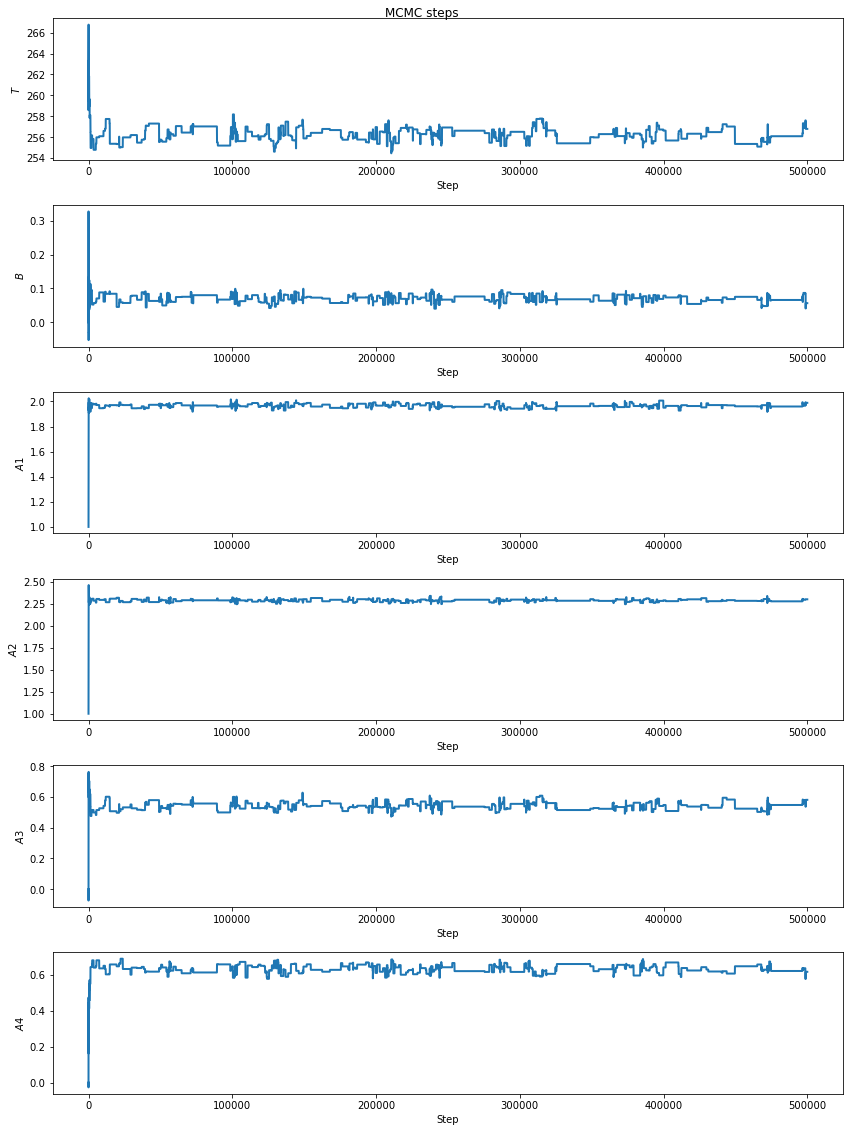

In [10]:
fig, axs = plt.subplots(6, 1, figsize=(12,16))

pars_labels = ['$T$', '$B$', '$A1$', '$A2$', '$A3$', '$A4$']

for i, ax in enumerate(axs):
    ax.plot(samples[:,i], lw=2)

    ax.set_xlabel('Step')
    ax.set_ylabel(pars_labels[i])
    # ax.set_xscale('log')

fig.suptitle('MCMC steps')
fig.tight_layout()

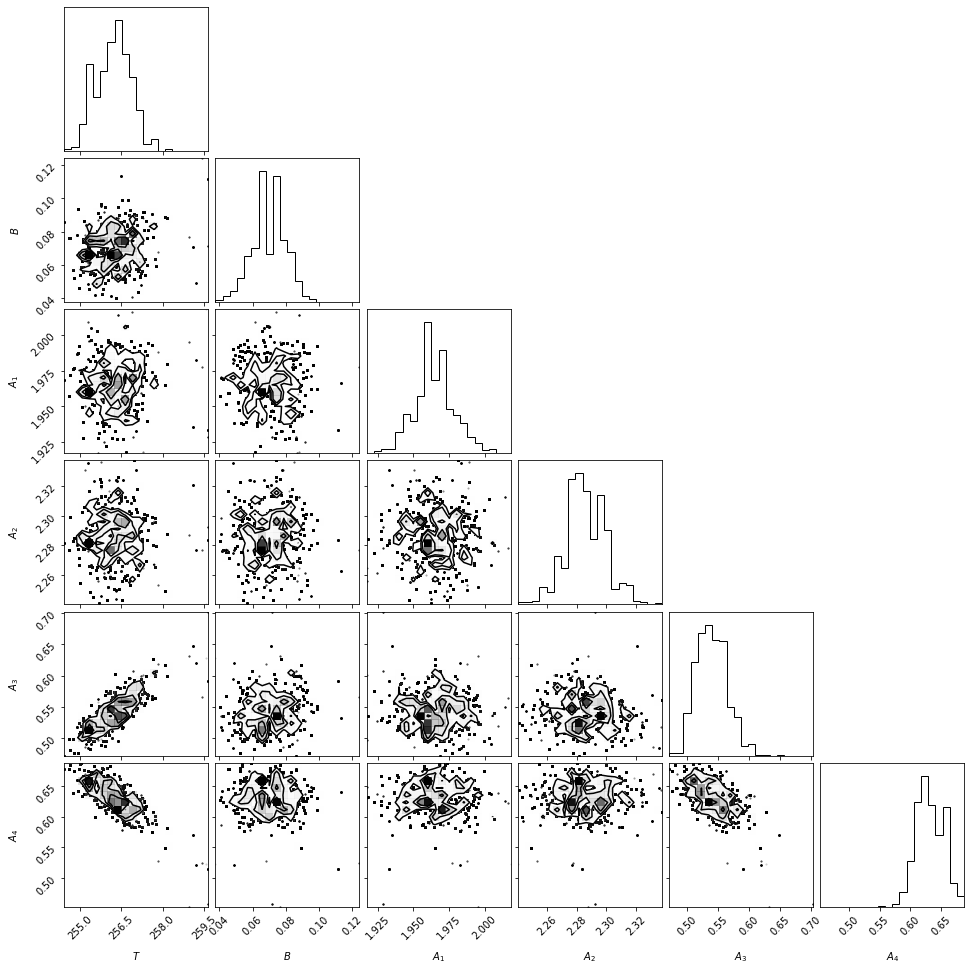

In [11]:
# corner plot of sample distribution
figure = corner.corner(samples[500:],
                        labels=['$T$', '$B$', '$A_1$', '$A_2$', '$A_3$', '$A_4$'])

In [12]:
# plot a sampling of 16 independent samples from the posterior in the space of the data, on the data
def draw_sample(param_dists):
    sample = np.array([np.random.choice(dist) for dist in param_dists])
    return sample

In [13]:
ndraws = 16
draws = np.array([draw_sample(samples[500:].T) for i in range(ndraws)])
draws.shape

(16, 6)

In [14]:
fits = np.empty((ndraws, len(signal)))
for i, draw in enumerate(draws):
    fits[i] = funcs.func_2sigs(time, *draw, T0=100)

Text(0.5, 1.0, 'Data set 11: 16 independent samples from the posterior')

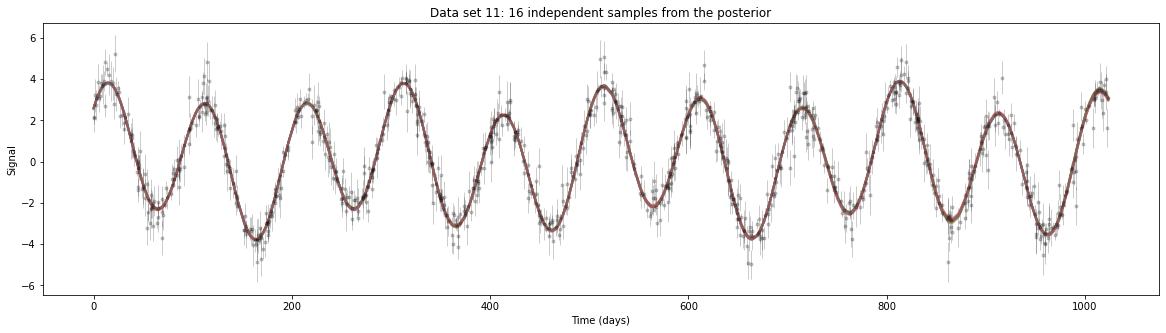

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.errorbar(time, signal, yerr=sigmas, ls='None', lw=1, color='k', marker='.', alpha=0.2)
for fit in fits:
    ax.plot(time, fit, lw=2, alpha=0.5)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Signal')
ax.set_title(f'Data set 11: 16 independent samples from the posterior')

### Problem 2

Same data set: residuals plotted and folded at the putative best-fit second period.

In [16]:
data = {
    'time' : data[0],
    'signal' : data[-1],
    'sigmas' : data[1]
}
T = 100

In [17]:
# linear least-squares fit
theta, cov = thissignal.fit_1sig(T)
B, A1, A2 = theta   # unpack best-fit params
A = np.sqrt(A1**2 + A2**2)  # overall amplitude
B_var, A1_var, A2_var = np.diag(cov)    # get variances
A_sigma = np.sqrt(A1_var+A2_var)        # overall error
snr = A/A_sigma                         # ~ signal-to-noise
print(f"Data set: A = {A:.3f}, A_sigma = {A_sigma:.3f} ==> SNR = {snr:.2f}")

# plug best-fit params back into the signal equation to get the best fit
fit = funcs.func_1sig(time, T, *theta)

# compute chi-squared to assess goodness of fit
loglike = funcs.get_loglike(signal, fit, sigmas)

Data set: A = 3.099, A_sigma = 0.020 ==> SNR = 156.06


In [18]:
# residuals
res = signal - fit

In [19]:
# best-fit second period
T1 = 259.5

Text(0.5, 0.98, '11th data set from pset2')

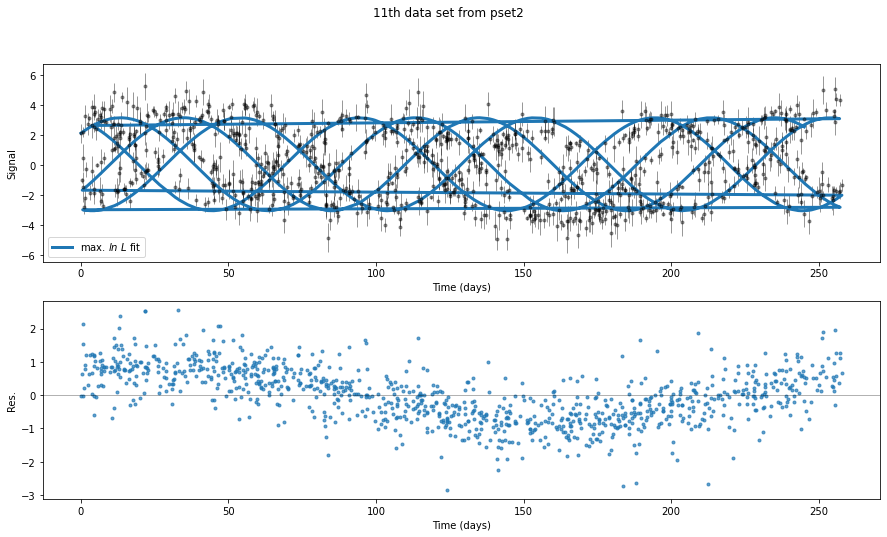

In [20]:
# plot data and fitted 100-day signal, and residuals
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].errorbar(time%T1, data['signal'], yerr=sigmas, lw=1, ls='None', color='k', marker='.', alpha=0.4)
axs[0].plot(time%T1, fit, lw=3, label=f'max. $ln\ L$ fit')
axs[0].set_ylabel('Signal')
axs[0].legend()

axs[1].plot(time%T1, res, ls='None', marker='.', alpha=0.7)
axs[1].set_ylabel('Res.')
axs[1].axhline(0, lw=1, color='k', alpha=0.3)

for ax in axs:
    ax.set_xlabel('Time (days)')

fig.suptitle(f'11th data set from pset2')

I'd argue that the model is believable because we can see the second signal captured visually in the residual plot. The fit in the top plot only includes the 100-day signal, so since we know there is a second signal, we DO expect there to be a single period signal if we fold at the putative best-fit second signal. Despite noise this single period is pretty clear in the residual plot.

### Problem 3

K-fold cross-validation for problem #2 of PS2.

In [21]:
K = 8
T = 100

In [22]:
# fit one signal to all but one eighth of each data set, for all eight held-out sets
def kfold_crossval_1sig(time, signal, sigmas, K=8):
    cut_size = int(len(time)/K)
    times = np.empty((K, len(time)-cut_size))
    fits = np.empty((K, len(time)))
    loglikes = np.zeros(K)
    for i in range(K):
        time_K = np.concatenate((time[:i*cut_size], time[(i+1)*cut_size:]))
        times[i] = time_K
        signal_K = np.concatenate((signal[:i*cut_size], signal[(i+1)*cut_size:]))
        sigmas_K = np.concatenate((sigmas[:i*cut_size], sigmas[(i+1)*cut_size:]))
        Signal = funcs.Signal(time_K, signal_K, sigmas_K)
        # fit one signal with a period of 100 days
        theta, cov = Signal.fit_1sig(T)
        # fit these parameters to all of the points
        fit_K = funcs.func_1sig(time, T, *theta)
        fits[i] = fit_K
        loglikes[i] = funcs.get_loglike(signal, fit_K, sigmas)
    return times, fits, loglikes

In [23]:
# fit two signals to all but one eighth of each data set, for all eight held-out sets
def kfold_crossval_2sigs(time, signal, sigmas, K=8):
    cut_size = int(len(time)/K)
    times = np.empty((K, len(time)-cut_size))
    fits = np.empty((K, len(time)))
    loglikes = np.zeros(K)
    for i in range(K):
        time_K = np.concatenate((time[:i*cut_size], time[(i+1)*cut_size:]))
        times[i] = time_K
        signal_K = np.concatenate((signal[:i*cut_size], signal[(i+1)*cut_size:]))
        sigmas_K = np.concatenate((sigmas[:i*cut_size], sigmas[(i+1)*cut_size:]))
        Signal = funcs.Signal(time_K, signal_K, sigmas_K)
        # fit one signal with a period of 100 days
        theta, cov = Signal.fit_2sigs(T=T1, T0=T)
        # fit these parameters to all of the points
        fit_K = funcs.func_2sigs(time, T1, *theta, T0=T)
        # fit_onlyK = funcs.func_2sigs(time_K, T1, *theta, T0=T)
        fits[i] = fit_K
        loglikes[i] = funcs.get_loglike(signal, fit_K, sigmas)
    return times, fits, loglikes

In [24]:
times1, fits1, loglikes1 = kfold_crossval_1sig(time, signal, sigmas, K=8)
times2, fits2, loglikes2 = kfold_crossval_2sigs(time, signal, sigmas, K=8)

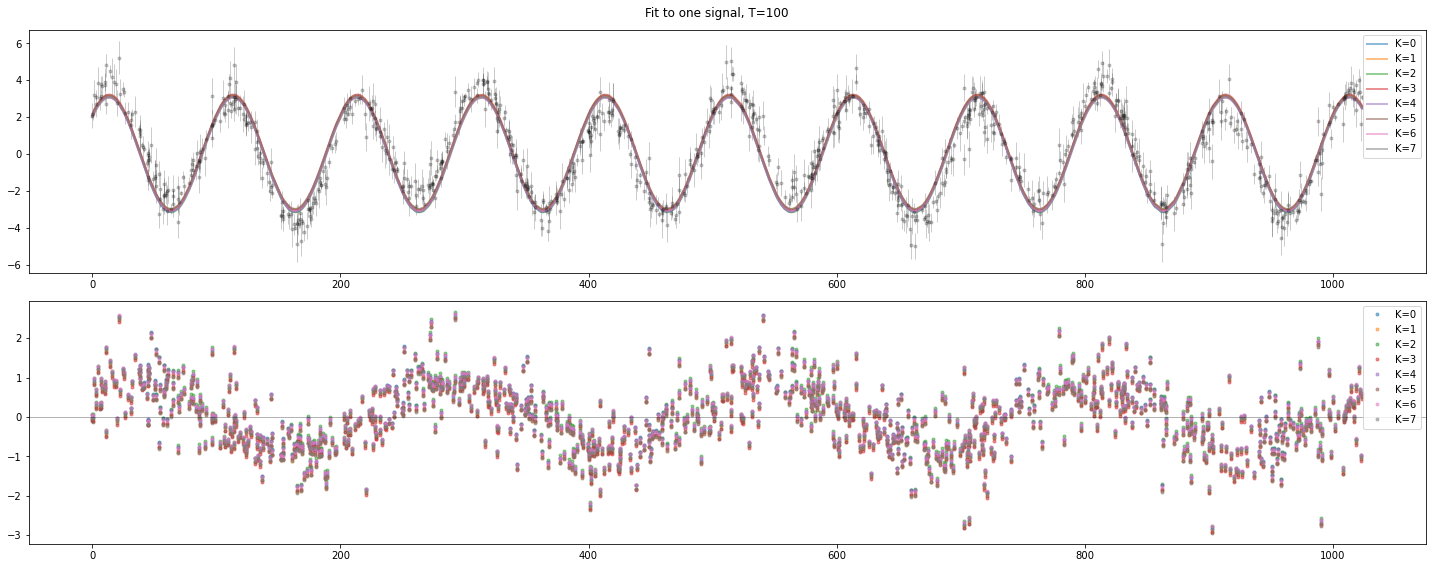

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))

axs[0].errorbar(time, signal, yerr=sigmas, lw=1, ls='None', color='k', marker='.', alpha=0.2)
for i in range(K):
    axs[0].plot(time, fits1[i], lw=2, alpha=0.5, label=f'K={i}')
    axs[1].plot(time, signal-fits1[i], ls='None', alpha=0.5, marker='.', label=f'K={i}')

axs[1].axhline(0, color='k', alpha=0.3, lw=1)
axs[0].legend()
axs[1].legend()
fig.suptitle('Fit to one signal, T=100')
fig.tight_layout()

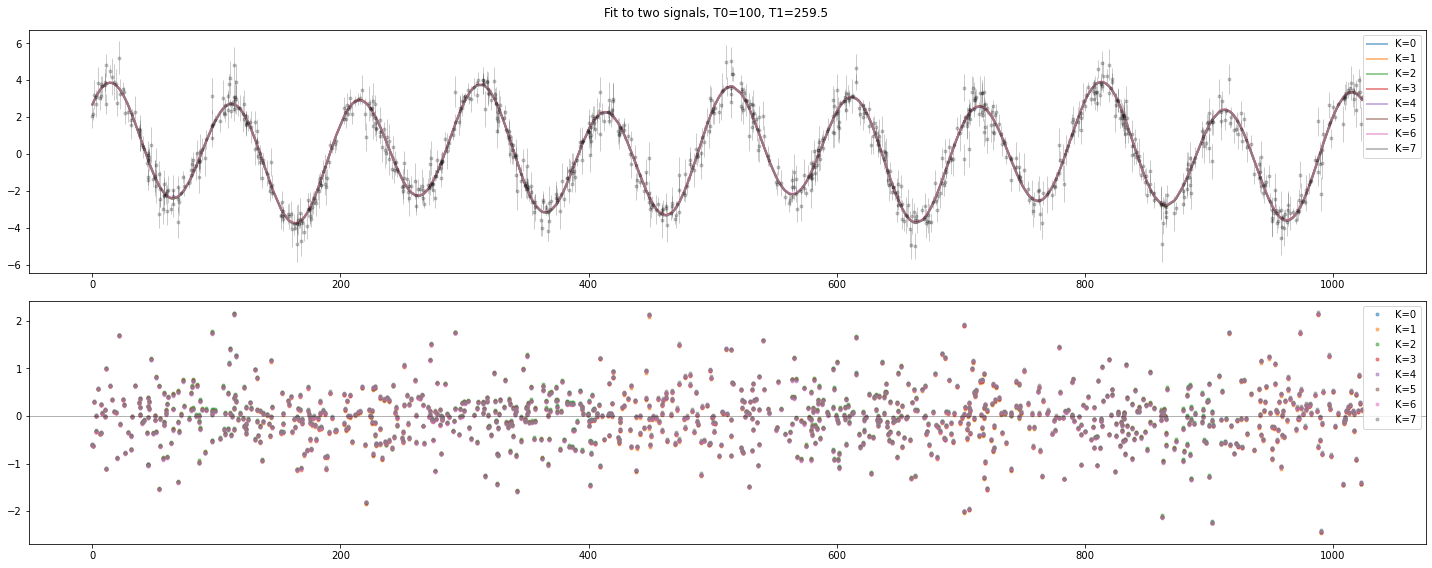

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))

axs[0].errorbar(time, signal, yerr=sigmas, lw=1, ls='None', color='k', marker='.', alpha=0.2)
for i in range(K):
    axs[0].plot(time, fits2[i], lw=2, alpha=0.5, label=f'K={i}')
    axs[1].plot(time, signal-fits2[i], ls='None', alpha=0.5, marker='.', label=f'K={i}')

axs[1].axhline(0, color='k', alpha=0.3, lw=1)
axs[0].legend()
axs[1].legend()
fig.suptitle('Fit to two signals, T0=100, T1=259.5')
fig.tight_layout()

Which is the better model in each case? (?)

#####  compute the AIC and BIC... which is a better model according to these? maybe make a table?

In [27]:
def AIC(k, loglike):    # where k is the number of parameters in the model
    return 2*k - 2*loglike

In [28]:
loglikes1, loglikes2

(array([-2106.60226361, -2114.34871425, -2133.75375451, -2121.35522839,
        -2113.35458854, -2122.48269463, -2111.11689903, -2111.32172083]),
 array([-481.47196158, -483.06080958, -482.89938337, -481.40926906,
        -481.60958757, -481.5520469 , -482.15836816, -483.2558937 ]))

In [29]:
aic1 = AIC(4, loglikes1)
aic2 = AIC(7, loglikes2)

In [30]:
aic1, aic2

(array([4221.20452721, 4236.69742851, 4275.50750901, 4250.71045679,
        4234.70917708, 4252.96538926, 4230.23379805, 4230.64344167]),
 array([976.94392316, 980.12161917, 979.79876674, 976.81853813,
        977.21917513, 977.1040938 , 978.31673632, 980.51178739]))

### Bonus Problem

Same as problem #3 but with the fully marginalized likelihood (Bayesian evidence).